# Etapa 1 analitica de datos

| Integrante        | Código     | Correo          |
|--------------------|------------|-----------------|
| Sebastián Ramírez | 202123415  | s.ramirez112    |
|  |   |     |
|  |   |     |

**Objetivo**
- Aplicar la metodología de analítica de textos para la construcción de soluciones de 
analítica alineadas con los objetivos de organizaciones en un contexto de aplicación. 


En esta etapa será científico de datos. El científico de datos tiene la responsabilidad de 
seguir un proceso replicable y de calidad, para entender los datos, prepararlos, construir el 
modelo analítico y evaluarlo, tanto a nivel cuantitativo como cualitativo. En este caso, cada 
grupo debe trabajar con opiniones que representan la voz de los habitantes locales para 
identificar las problemáticas de su entorno en términos de los ODS 1, 3 y 4, relacionados 
con “Fin de la pobreza”, “Salud y bienestar” y “Educación de calidad”. En esa tarea se 
requiere construir un modelo analítico que permita relacionar de forma automática nuevas 
opiniones, al igual que analizar las palabras que llevan a relacionar una opinión con un ODS.

In [12]:
pip install openpyxl nltk

     ---------------------------------------- 0.0/41.5 kB ? eta -:--:--
     ------------------ ------------------- 20.5/41.5 kB 640.0 kB/s eta 0:00:01
     -------------------------------------- 41.5/41.5 kB 504.6 kB/s eta 0:00:00
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ------------------------- -------------- 0.9/1.5 MB 19.8 MB/s eta 0:00:01
   ---------------------------------------  1.5/1.5 MB 19.2 MB/s eta 0:00:01
   ---------------------------------------- 1.5/1.5 MB 15.9 MB/s eta 0:00:00
   ---------------------------------------- 0.0/276.2 kB ? eta -:--:--
   --------------------------------------- 276.2/276.2 kB 16.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/102.2 kB ? eta -:--:--
   ---------------------------------------- 102.2/102.2 kB 5.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: C:\Users\sebas\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [24]:
# Seaborn
import seaborn as sns 
import sklearn as sklearn

# Librerías para el procesamiento de texto
import nltk
from nltk.corpus import stopwords
import string
import re

#Librerías para la visualización
import matplotlib.pyplot as plt

# Librerias para operaciones matematicas
import numpy as np
import pandas as pd

from sklearn import tree
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold 
from sklearn.feature_extraction.text import CountVectorizer as CountVectorizer


## Entendimiento y preparacion de datos

Encabezado del DataFrame:
                                              textos  labels
0  "Aprendizaje" y "educación" se consideran sinó...       4
1  Para los niños más pequeños (bebés y niños peq...       4
2  Además, la formación de especialistas en medic...       3
3  En los países de la OCDE se tiende a pasar de ...       4
4  Este grupo se centró en las personas que padec...       3

Valores únicos en la columna 'labels': [4 3 1]

Distribución de las categorías en la columna 'labels':
labels
4    1025
3     894
1     505
Name: count, dtype: int64

Porcentaje de cada categoría en la columna 'labels':
labels
4    42.285479
3    36.881188
1    20.833333
Name: proportion, dtype: float64


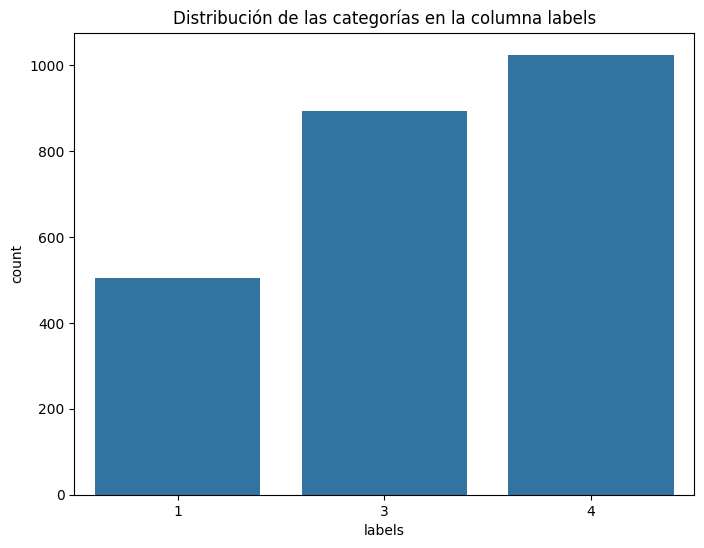

In [14]:
## // CARGA DEL ARCHIVO //

# Cargar los archivos de Excel como DataFrames
train_data = pd.read_excel('data/Datos_proyecto.xlsx')
test_data = pd.read_excel('data/Datos de prueba_proyecto.xlsx')

# Separaracion de las columnas en 'textos' y 'labels'
textos_train = train_data['textos']
labels_train = train_data['labels']

# Imprimir el encabezado del DataFrame
print("Encabezado del DataFrame:")
print(train_data.head())

## // BALANCE DE LA CATEGORIA LABELS //

# Obtener los valores únicos de la columna 'labels'
unique_labels = train_data['labels'].unique()
print("\nValores únicos en la columna 'labels':", unique_labels)

# Calcular la distribución de las categorías en la columna 'labels'
label_distribution = train_data['labels'].value_counts()
print("\nDistribución de las categorías en la columna 'labels':")
print(label_distribution)

# Calcular el porcentaje de cada categoría
label_percentage = train_data['labels'].value_counts(normalize=True) * 100
print("\nPorcentaje de cada categoría en la columna 'labels':")
print(label_percentage)

# Visualizar la distribución de las categorías
plt.figure(figsize=(8, 6))
sns.countplot(x='labels', data=train_data)
plt.title('Distribución de las categorías en la columna labels')
plt.show()



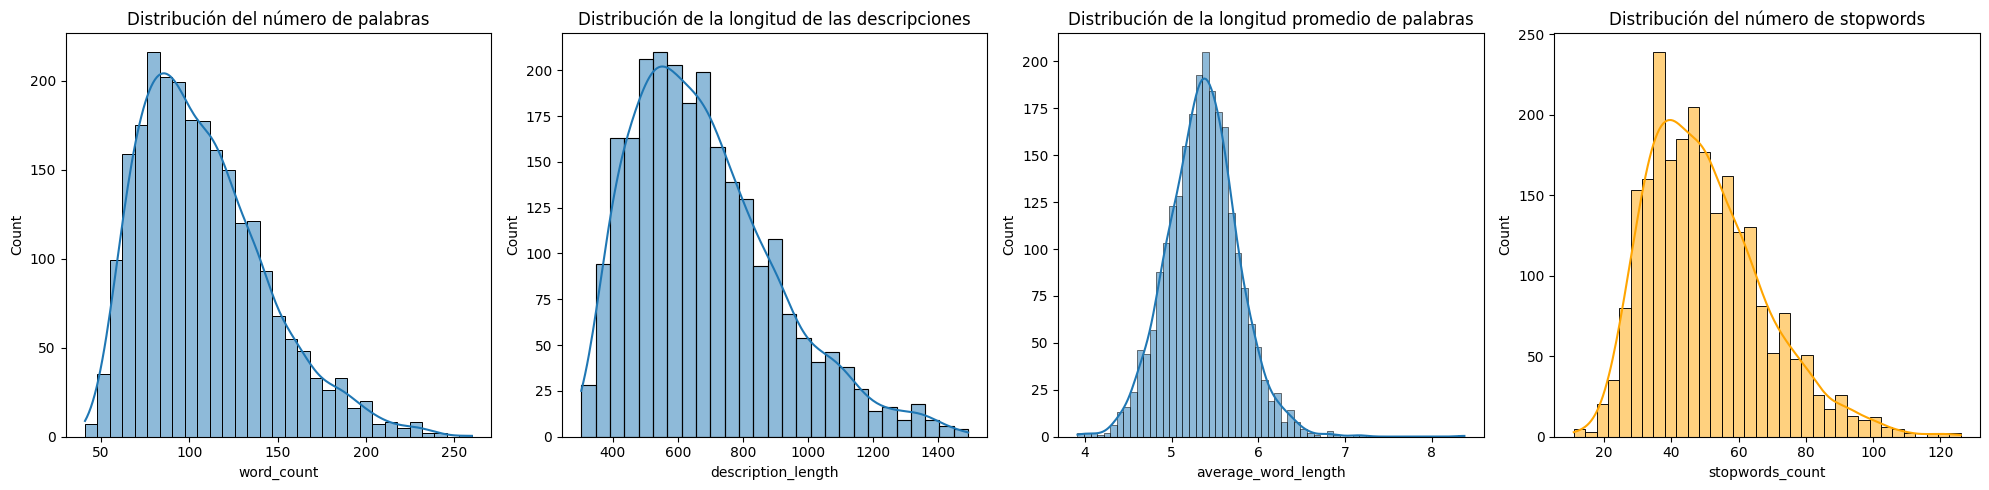

                                              textos  \
0  "Aprendizaje" y "educación" se consideran sinó...   
1  Para los niños más pequeños (bebés y niños peq...   
2  Además, la formación de especialistas en medic...   
3  En los países de la OCDE se tiende a pasar de ...   
4  Este grupo se centró en las personas que padec...   

                                      textos_limpios  stopwords_count  
0  aprendizaje y educación se consideran sinónimo...               22  
1  para los niños más pequeños bebés y niños pequ...               30  
2  además la formación de especialistas en medici...               36  
3  en los países de la ocde se tiende a pasar de ...               51  
4  este grupo se centró en las personas que padec...               41  
                                              textos  labels
0  aprendizaje y educación se consideran sinónimo...       4
1  para los niños más pequeños bebés y niños pequ...       4
2  además la formación de especialistas en medic

In [ ]:
## // ANÁLISIS Y LIMPIEZA DE TEXTO //
# Descargar stopwords en español si no están disponibles
try:
    stopwords_es = stopwords.words('spanish')
except LookupError:
    nltk.download('stopwords')
    stopwords_es = stopwords.words('spanish')

# -------------------------------
# Función para identificar stopwords en un texto
# -------------------------------
def identify_stopwords(text):
    words = text.split()
    stopwords_list = [word for word in words if word.lower() in stopwords_es]
    return stopwords_list

# Crear columna con stopwords encontradas en cada texto
train_data['stopwords'] = train_data['textos'].apply(identify_stopwords)

# Contar cuántas stopwords hay por texto
train_data['stopwords_count'] = train_data['stopwords'].apply(len)

# -------------------------------
# Estadísticas básicas
# -------------------------------
train_data['word_count'] = train_data['textos'].apply(lambda x: len(x.split()))
train_data['description_length'] = train_data['textos'].apply(len)
train_data['average_word_length'] = train_data['textos'].apply(
    lambda x: np.mean([len(word) for word in x.split()]) if len(x.split()) > 0 else 0
)

# -------------------------------
# Histogramas
# -------------------------------
plt.figure(figsize=(20, 5))

plt.subplot(1, 4, 1)
sns.histplot(train_data['word_count'], kde=True)
plt.title('Distribución del número de palabras')

plt.subplot(1, 4, 2)
sns.histplot(train_data['description_length'], kde=True)
plt.title('Distribución de la longitud de las descripciones')

plt.subplot(1, 4, 3)
sns.histplot(train_data['average_word_length'], kde=True)
plt.title('Distribución de la longitud promedio de palabras')

plt.subplot(1, 4, 4)
sns.histplot(train_data['stopwords_count'], kde=True, color='orange')
plt.title('Distribución del número de stopwords')

plt.tight_layout()
plt.show()

# -------------------------------
# Función para limpiar texto
# -------------------------------
def clean_text(text):
    # 1. Eliminar paréntesis, comillas y puntuación, PERO mantener acentos y ñ
    text = re.sub(r"[\"'“”‘’]", "", text) 
    text = re.sub(r"[\(\)\[\]\{\}]", "", text)
    # eliminar signos pero mantener tildes y ñ
    text = re.sub(r"[^\w\sáéíóúÁÉÍÓÚñÑ]", "", text, re.UNICODE)
    
    # 2. Convertir a minúsculas
    text = text.lower()
    
    # 3. Eliminar espacios extra
    text = re.sub(r"\s+", " ", text).strip()
    
    return text

# Aplicar limpieza
train_data['textos_limpios'] = train_data['textos'].apply(clean_text)

# -------------------------------
# Vista previa
# -------------------------------
print(train_data[['textos', 'textos_limpios', 'stopwords_count']].head())


# -------------------------------
# Generacion del dataset limpio
# -------------------------------
train_data_clean = train_data[['textos_limpios', 'labels']].copy()
train_data_clean.rename(columns={'textos_limpios': 'textos'}, inplace=True)

print(train_data_clean.head())


In [21]:
# // ANÁLISIS DE COMPLETITUD DE LOS DATOS //

# Verificar si hay valores nulos en el DataFrame limpio
null_values = train_data_clean.isnull().sum()
print("Valores nulos por columna en el DataFrame limpio:")
print(null_values)


Valores nulos por columna en el DataFrame limpio:
textos    0
labels    0
dtype: int64


## Modelado y evaluacion

### **Algoritmo 1**- > CountVectorizer + Árboles de Decisión

In [27]:
## / Modelado //

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    train_data_clean['textos'], train_data_clean['labels'], test_size=0.2, random_state=42
)

# -------------------------------
# CountVectorizer
# -------------------------------


vectorizer = CountVectorizer(stop_words=stopwords_es)
X_train_vectorized = vectorizer.fit_transform(X_train)
# Transformar los textos de prueba
X_test_vectorized = vectorizer.transform(X_test)


# -------------------------------
# Espacio de búsqueda para GridSearchCV
# -------------------------------
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Inicializar DecisionTreeClassifier
tree = DecisionTreeClassifier(random_state=42)

# Inicializar GridSearchCV
grid_search = GridSearchCV(tree, param_grid, cv=3, scoring='accuracy')

# Ajustar GridSearchCV a los datos de entrenamiento
grid_search.fit(X_train_vectorized, y_train)

# Imprimir los mejores parámetros encontrados
print("Mejores parámetros encontrados:", grid_search.best_params_)

# Obtener el mejor modelo
best_tree = grid_search.best_estimator_

# Predecir las etiquetas para el conjunto de prueba
y_pred = best_tree.predict(X_test_vectorized)

# Imprimir el informe de clasificación
print(classification_report(y_test, y_pred))

Mejores parámetros encontrados: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5}
              precision    recall  f1-score   support

           1       0.88      0.87      0.87       112
           3       0.90      0.93      0.92       168
           4       0.97      0.95      0.96       205

    accuracy                           0.92       485
   macro avg       0.92      0.92      0.92       485
weighted avg       0.92      0.92      0.92       485



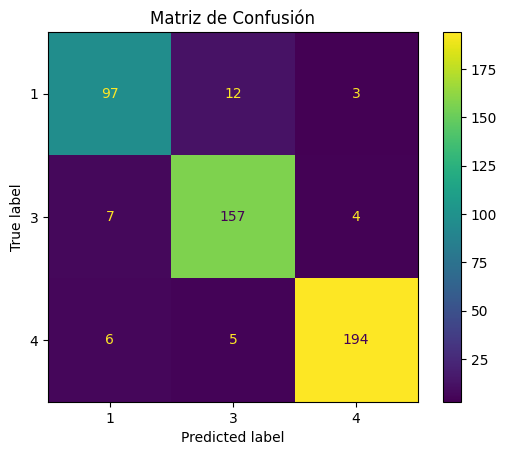

Top 10 palabras para la clase 1:
          word    n
0      pobreza  228
1       países   69
2       pobres   68
3        niños   48
4     ingresos   46
5     personas   45
6      hogares   42
7       social   31
8  crecimiento   30
9     infantil   30


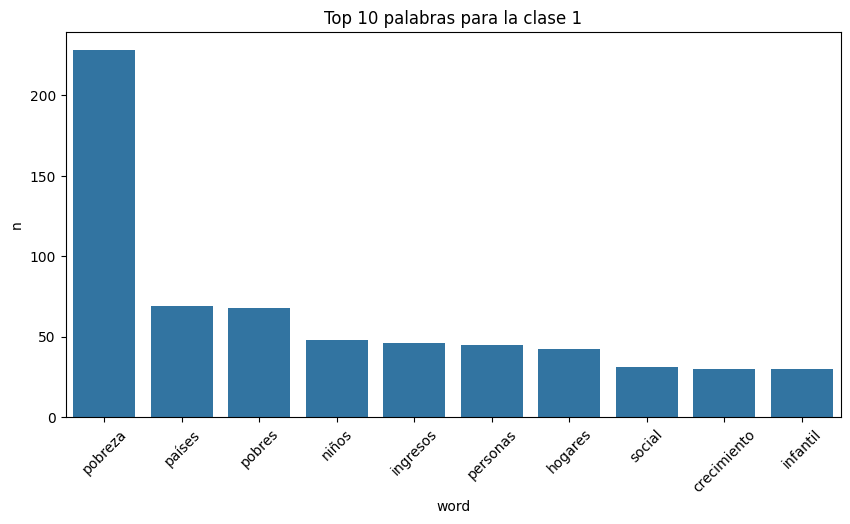

Top 10 palabras para la clase 3:
        word    n
0      salud  224
1   atención  135
2  servicios   89
3     países   81
4     mental   48
5   personas   44
6    sistema   41
7       ocde   41
8    médicos   41
9   nacional   39


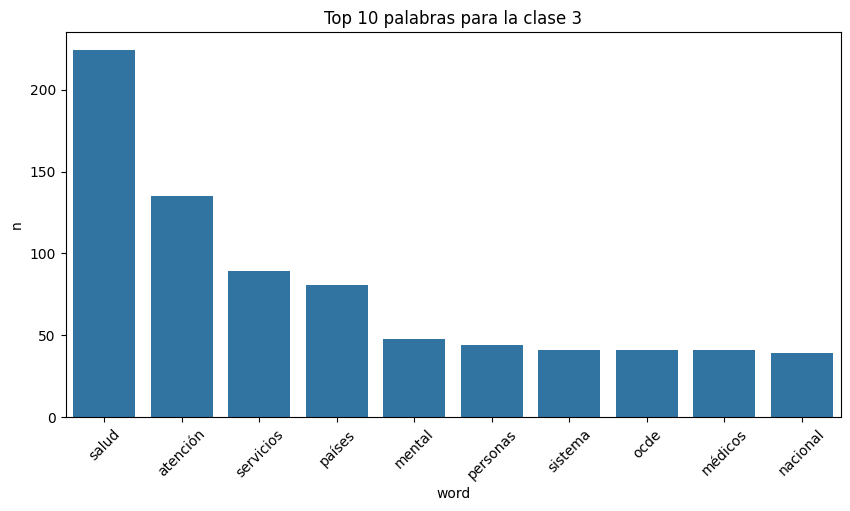

Top 10 palabras para la clase 4:
          word    n
0    educación  207
1  estudiantes  150
2     escuelas  116
3  aprendizaje   86
4      sistema   66
5     docentes   64
6     superior   57
7       países   55
8   evaluación   54
9         años   54


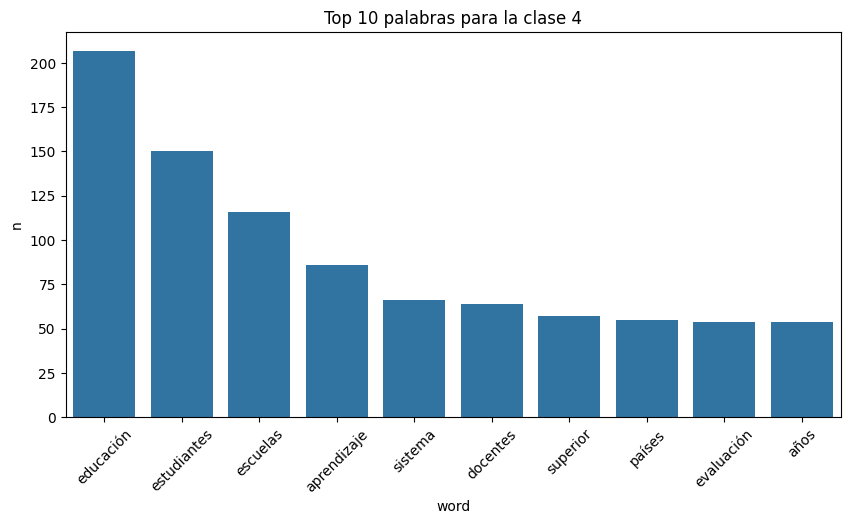

Accuracy global: 0.9237113402061856
Accuracy balanceada: 0.9156455671699574


In [28]:
# // EVALUACIÓN //

# -------------------------------
# Matriz de confusión
# -------------------------------
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_tree.classes_)
disp.plot()
plt.title('Matriz de Confusión')
plt.show()

# -------------------------------
# Palabras más relevantes por categoría
# -------------------------------
def plot_top_words(model, vectorizer, n=10):
    feature_names = vectorizer.get_feature_names_out()
    for i, class_label in enumerate(best_tree.classes_):
        # Obtener los índices de las muestras predichas como la clase actual
        class_indices = np.where(y_pred == class_label)[0]
        
        # Si no hay muestras predichas para esta clase, pasar a la siguiente
        if len(class_indices) == 0:
            print(f"No hay muestras predichas para la clase {class_label}, pasando a la siguiente clase.")
            continue
        
        # Obtener los textos correspondientes a las muestras de la clase actual
        class_texts = X_test.iloc[class_indices]
        
        # Vectorizar los textos de la clase actual
        class_vectors = vectorizer.transform(class_texts)
        
        # Sumar los conteos de palabras para la clase actual
        word_counts = np.array(class_vectors.sum(axis=0)).flatten()
        
        # Obtener los índices de las palabras más frecuentes
        top_indices = word_counts.argsort()[-n:][::-1]
        
        # Obtener las palabras más frecuentes
        top_words = [feature_names[i] for i in top_indices]
        
        # Crear un DataFrame con las palabras y sus conteos
        df = pd.DataFrame(list(zip(top_words, word_counts[top_indices])), columns=['word', 'n'])
        
        # Imprimir las palabras más relevantes para la clase actual
        print(f"Top {n} palabras para la clase {class_label}:")
        print(df)
        
        # Crear un gráfico de barras para las palabras más relevantes
        plt.figure(figsize=(10, 5))
        sns.barplot(x='word', y='n', data=df)
        plt.title(f'Top {n} palabras para la clase {class_label}')
        plt.xticks(rotation=45)
        plt.show()

plot_top_words(best_tree, vectorizer, n=10)

# -------------------------------
# Accuracy global
# -------------------------------
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy global: {accuracy}')

# -------------------------------
# Accuracy balanceada
# -------------------------------
balanced_accuracy = sklearn.metrics.balanced_accuracy_score(y_test, y_pred)
print(f'Accuracy balanceada: {balanced_accuracy}')